<a href="https://colab.research.google.com/github/lorenafreitas/SkinLesions_HAM10000/blob/master/LorenaFreitas_SkinLesionClassification_ExploreData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### The Problem:

Build and evaluate a deep learning model that classifies a dermoscopic image as one of seven following skin lesion classes: Melanoma (**mel**), Melanocytic nevus (**nv**), Basal cell carcinoma (**bcc**), Actinic keratosis / Bowen’s disease (**akiec**), Benign keratosis (**bkl**), Dermatofibroma (**df**), Vascular lesion (**vasc**). 


### The Data:
HAM10000, downloadable from: https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000



### Some ideas to explore:
* Explore different model architectures / hyper parameter settings and compare their performance.
* The data set is quite small, what kind of implications does it have on your choices to solve the problem?
* Select and describe a suitable set of training techniques.
* Suggest a performance metric for the model and explain its clinical relevance.
* Specify a verification method for the final model and verify the model.
* Comment on the statistical significance of the verification results.
* You can split the dataset as you wish but motivate and explain your choices.
* Visualize the results and the learning procedure.
* Impress us with your programming skills! 



---



---


# 1) Download dataset
Install Kaggle, download dataset, save it in Drive to avoid losing everything next time I use Colab :)

In [0]:
!pip install kaggle


In [0]:
!mkdir ~/.kaggle

In [0]:
import json
token = {"username":"lorenafreitas","key":"63b0319399b68a14cbdcf1fa352ecb92"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json


In [0]:
!kaggle config set -n path -v{/content}

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets list -s skin-cancer-mnist-ham10000

In [0]:
from google.colab import drive
drive.mount('/content/drive')

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000  -p "/content/drive/My Drive/Colab Notebooks/Data/SkinLesions/"

100% 5.20G/5.20G [01:50<00:00, 29.3MB/s]
100% 5.20G/5.20G [01:51<00:00, 50.2MB/s]


In [0]:
import os

root_path = 'drive/My Drive/Colab Notebooks/Data/SkinLesions/'
os.chdir(root_path)
!unzip -q -o "skin-cancer-mnist-ham10000.zip"

# 2) Data exploration and wrangling

In [0]:
# Import essential libraries
import os
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.utils import compute_sample_weight, compute_class_weight


import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D
from keras import backend as K
import itertools
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras_applications.densenet import DenseNet201

In [7]:
base_path = '/content/drive/My Drive/Colab Notebooks/Data/SkinLesions/'
df = pd.read_csv(os.path.join(base_path, 'HAM10000_metadata.csv'))
df.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [5]:
df.dx.unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [0]:
# Map diagnosis (dx) to lesion full name
lesion_dict = {
    'akiec': 'Actinic keratosis',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis',
    'df': 'Dermatofibroma',
    'nv': 'Melanocytic nevus',
    'mel': 'Melanoma',
    'vasc': 'Vascular lesion'}

In [13]:
print(os.listdir(base_path))

['HAM10000_metadata.csv', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv', 'skin-cancer-mnist-ham10000.zip', 'HAM10000_images_part_1', 'HAM10000_images_part_2', 'ham10000_images_part_1', 'ham10000_images_part_2']


In [83]:
# Map image names to their full path
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_path, '*', '*.jpg'))}

# Add columns to dataframe containing path to image and categorical value for the diagnostic
df['cell_class'] = df['dx'].map(lesion_dict.get)
df['img_path'] = df['image_id'].map(image_path_dict.get)
df['lesion_cat'] = pd.Categorical(df['dx']).codes # 7 values: 0 to 6
#df.sample(3)

# Create a dict mapping lesion names to their categories
dict_lesion_cat = pd.Series(df['cell_class'].values,df['lesion_cat']).sort_index().to_dict()
dict_lesion_cat

{0: 'Actinic keratosis',
 1: 'Basal cell carcinoma',
 2: 'Benign keratosis',
 3: 'Dermatofibroma',
 4: 'Melanoma',
 5: 'Melanocytic nevus',
 6: 'Vascular lesion'}

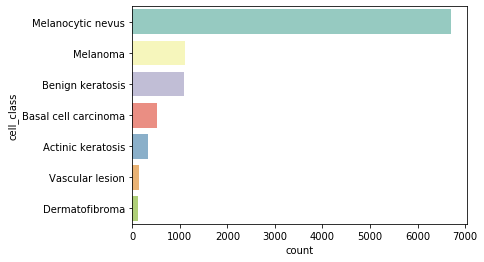

In [10]:
# Visualise class distribution
ax = sns.countplot(y="cell_class", data=df, palette="Set3", order= df['cell_class'].value_counts().index)

**Unbalanced dataset**: The Lesion Classes have very different sample sizes, which may be a problem when training our classifier (e.g., it may learn to just classify *everything* as Melanocytic Nevus, as it will have a higher chance to get it right!). I have considered four potential options on how to deal with this problem:

* Undersampling the highly expressed classes by deleting samples until the dataset is balanced. Drawback: losing a lot of good quality data!
* Oversampling the minority classes through imbalanced data augmentation. Drawback: an uneven amount of synthetic data in each class, leading to one class with very rich variability and occupying a lot of the image space, with other classes having a lot of datapoints in a very limited space with low variation.
* Telling the classifier to give classes different weights according to their representation in the sample, so that it learns more from the underrepresented classes. Drawback: if the dataset is not representative the class distribution in the real-world, it may end up biased to your sample.
* Not do anything! Deep learning has a tendency to deal well with imbalanced datasets, so it's worth to at least try it out. 

I thus started with the fourth option. As we will see, I eventually decided to go for the third option instead. 

Next, I make all the images the same size to use CNNs, as every image will then have the same number of outputs passed on to adjacent layers. However, these images are relatively big, so I resize them to make the algorithms run faster, hopefully without losing too much information.

In [0]:
# Resize all images so they're lighter to handle, and store them on a new column of the data frame

# For my first attempt, I resised images to 80x60 to make the training faster
df['image'] = df['img_path'].map(lambda x: np.asarray(Image.open(x).resize((80,60))))


# For my second attempt (way down in the notebook), I resised images to 224x224 to be able to use Keras' pretrained models
# df['image'] = df['img_path'].map(lambda x: np.asarray(Image.open(x).resize((224,224))))

In [0]:
# Store the new dataframe, so I don't have to run the resizing every time

#df.to_pickle(os.path.join(base_path, 'HAM10000_metadata.pkl'))
df = pd.read_pickle(os.path.join(base_path, 'HAM10000_metadata.pkl')) # Read 80 x 60 images

#df.to_pickle(os.path.join(base_path, 'HAM10000_metadata224x224.pkl'))
#df = pd.read_pickle(os.path.join(base_path, 'HAM10000_metadata224x224.pkl')) # Read 224 x 224 images


I've personally never seen these lesions before, so I wanted to see what they look like. For example, are there pairs of lesions that look more like each other?

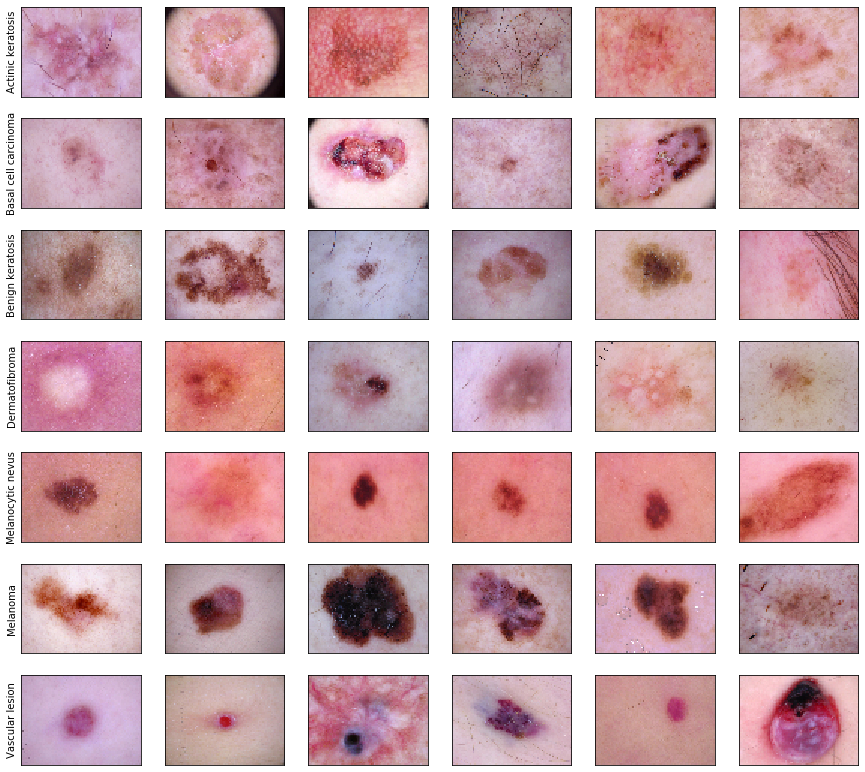

In [22]:
# Plot 6 samples from each class, setting the random state from reproducibility:
n_samples = 6
n_cell_types = len(df["cell_class"].unique())
fig, m_axs = plt.subplots(n_cell_types, n_samples, figsize = (2.5*n_samples, 2*7))

for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_class']).groupby('cell_class')):
    n_axs[0].set_ylabel(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=523).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.tick_params(labelbottom=False, labelleft=False, length=0)
        


# 3) Splitting data into train/test and validation sets and further preprocessing

First, I separated 10% of the dataset as a validation subset to be used after training and testing the model. This was done in a stratified way based on skin lesion category (using the stratify=df['lesion_cat'] parameter setting), to garantee that the validation set contains a similar distribution of classes as the original data. The dataset is relatively small, and I wanted to use as much data as possible for training, hence the decision to leave only 10% for validation.

In [0]:
from sklearn.model_selection import train_test_split

# Split the data into train and test set
x_train, x_val, y_train, y_val = train_test_split(np.array(df['image'].tolist()), df['lesion_cat'], test_size = 0.1, random_state = 2, stratify=df['lesion_cat'])

array([1, 2, 5, 4, 3, 0, 6])

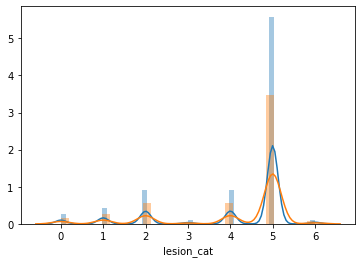

In [24]:
# Verify that the distribution of the validation set resembles that of the training+testing set, as I intended
sns.distplot(y_train)
sns.distplot(y_val)

y_val.unique()

Then, I normalise data, such that the CNN won't need to learn the baseline, and can instead concentrate on learning about the variations in the data.

In [0]:
def normalise(x):
  
  x_mean = np.mean(x)
  x_std = np.std(x)

  return (x - x_mean) / x_std

x_train = normalise(x_train)
x_val = normalise(x_val)

One-hot encode the labels for multi-class classification using my home-cooked classifier.

In [0]:
from keras.utils import to_categorical

# One hot encoding 
y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val, num_classes = 7)

n_train = len(x_train)
n_val = len(x_val)

# 4) Prepare model

First, I select an **optimiser** to handle the parameters my network's parameters (such as filters' kernel sizes and nodes' weights). **Adam** is widely known for quickly achieving good results because it combines the advantages of two extensions of Stochastic Gradient Descent, namely the Adaptive Gradient Algorithm (AdaGrad) which is ideal for computer vision problems, and the Root Mean Square Propagation (RMSProp), which performs well on noisy datasets, both of which apply in this case. So I went for this option. 

In [0]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

## Model architecture considerations

Below I prepare a simple sequential model losely based on the VGG architecture, as I have used it for a multiclass image classification problem that I have previously worked on, with good results.

This first layer (input layer) sets some important parameters, such as the filter size (the number of output filters in the convolution), the kernel size (which is the height and width of the 2D convolution window), the activation function (ReLU adds non-linearity to the model, it is the most common activation function), and the input shape, which is the size of our images (which I resized to 60 x 80 x 3 channels as a preprocessing step). Note that these hyperparameters have been hardcoded here for simplicity but could be optimised using GridSearchCV, as I discuss in "Future Directions". 

The MaxPool2D layers reduce the spatial size of the incoming features, so they help to reduce the amount of parameters and computation in the network. As a consequence,this helps to reduce overfitting.

I then add a Flatten layer to transform the spatial features learned and extracted by the convolutional layers output into a sequence of vectors that can be used by following dense layers. At this point I also add a Dropout layer with value 0.5, meaning half of the nodes will be dropped. This works as a sort of regularisation: it stops the model from overfitting the training data by temporarily ignoring information from random nodes, simulating a sparse activation which in turn encourages the network to actually learn a sparse representation.

Finally, for the final layer is a softmax activation layer which detects the probability of each sample to belong to each class, and forces the total predicted probabilities to sum up to 1. 

I chose "categorical_crossentropy" as a loss as it assumes that the probabilities of all classes sum up to 1, which is ideal when we have a situation where a sample should be assigned to one class only. Then I chose "accuracy" as a metric since it is similar to the loss function (but is not used for training – only for evaluation). 

In [0]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

def prepare_model():
      #Create model
      model = models.Sequential()
      model.add(layers.Conv2D(32,(3,3), activation = 'relu', input_shape=(60,80,3)))
      model.add(layers.MaxPool2D((2,2)))
      model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
      model.add(layers.MaxPool2D((2,2)))
      model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
      model.add(layers.MaxPool2D((2,2)))
      model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
      model.add(layers.MaxPool2D((2,2)))
      model.add(layers.Flatten())
      model.add(layers.Dropout(0.5))
      model.add(layers.Dense(512, activation = 'relu'))
      model.add(layers.Dense(7, activation = 'softmax')) #sotmax = probabilities

      # Summarise     
      #model.summary()

      # Compile
      model.compile(optimizer = optimizer , loss='categorical_crossentropy', 
                    metrics=['accuracy'])

      return model

## Visualising the architechture

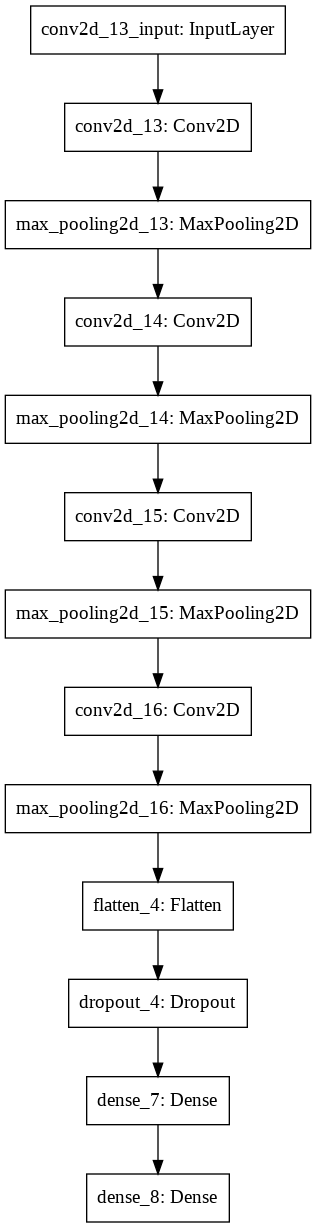

In [113]:
from keras.utils import plot_model
model = prepare_model();
plot_model(model, to_file=os.path.join(base_path ,'model.png'))

## Data Augmentation: an approach to deal with the small sample size

Since the dataset is relatively small, we can benefit from using Data Augmentation during training. This means that we can generate extra images as simple random affine transforms (e.g., rotations, streches, zooming in/out, etc.) from the original ones and also use them for training.   

In [0]:
#Data augmentation

def prepare_datagen():
      train_datagen = ImageDataGenerator(rescale= 1./255, # scale between 0 and 1
                                        rotation_range=180,
                                        width_shift_range=0.1,
                                        height_shift_range=0.1,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='nearest')

      val_datagen = ImageDataGenerator(rescale= 1./255)

      return train_datagen, val_datagen

# Adaptation and Learning

Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates.  This ensures we converge more quickly at the beginning if we start with large running rates, but still efficiently reach the global minimum of the loss function by **reducing the learning rate when necessary**.


The first callback below (*ReduceLROnPlateau*) monitors a quantity and if no improvement is seen for a 'patience' number of epochs (in our case, 3), the learning rate is reduced by (factor) half.

The second callback (*Early Stopping*) **stops training once the model performance stops improving on a hold out testing dataset**, to avoid overfitting on the training dataset. This means we can initially set up a large number of training epochs without worrying that the model will overfit, since it will stop early if needed.

In [0]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
# Setting early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')

## Additional considerations

**Dealing with the small size of the dataset:** As mentioned earlier, since this is a relatively small dataset (~10k images), I employ a data augmentation procedure based on generating random rotations, stretches or horizontal flips of the original images. This is done by creating a new "augmented" set of the entire dataset at each batch iteration. Based on this criteria, our model will see *n_batches* times *size_of_training_subset* images during training, stratified in the same way as the original dataset is. I chose to augment all classes equally (instead of augmenting underrepresented classes only, or deleting original samples from the overrepresented class as a preprocessing step), to avoid having different amounts of variation per class (i.e., the overrepresented class would have very rich variation, whereas the underrepresented classes would be a large collection of images with very small variability) or losing good quality, original samples in the latter case. In addition, I used generators to yield augmented images on the go instead of generating all images and storing them as a preprocessing step, to avoid having large amounts of data loaded at the same time. 

**Generalisation to other datasets:**  As an extra effort to guarantee that my results generalise to other datasets, I employ a cross-validation approach where I randomly split the training data set into "training" and "testing" subsets several times, and report the average accuracy of all the folds as my final result.


In [116]:
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight

 
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define 2-fold cross validation test harness (I wanted to do 10-fold, but it would be too time consuming!)
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
train_datagen, val_datagen = prepare_datagen()
cvscores = []
batch_size = 32
i_counter = 1
classLabels = np.argmax(y_train,axis=1)
for train, test in kfold.split(x_train, classLabels):
      print('\n ===== Fold: '+ str(i_counter) + ' ===== \n')

      # create and compile model
      model = prepare_model()
      
      # Create generator flows
      train_generator = train_datagen.flow(x_train[train],y_train[train], batch_size=batch_size)
      test_generator = val_datagen.flow(x_train[test],y_train[test], batch_size=batch_size)
      
      # Fit the model
      history = model.fit_generator(train_generator, steps_per_epoch=n_train // batch_size, 
                                    validation_data=test_generator, epochs=50, verbose=0, 
                                    callbacks=[learning_rate_reduction, early_stopping])
      
      # Evaluate the model
      scores = model.evaluate_generator(test_generator, verbose=0)
      
      # Print/Log information
      print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
      cvscores.append(scores[1] * 100)
      i_counter += 1
print("%.2f%% (+/- %.2f%%) \n" % (np.mean(cvscores), np.std(cvscores)))


 ===== Fold: 1 ===== 


Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
acc: 75.08%

 ===== Fold: 2 ===== 


Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.0001.
acc: 72.17%
73.63% (+/- 1.46%) 



## Visualising the learning history

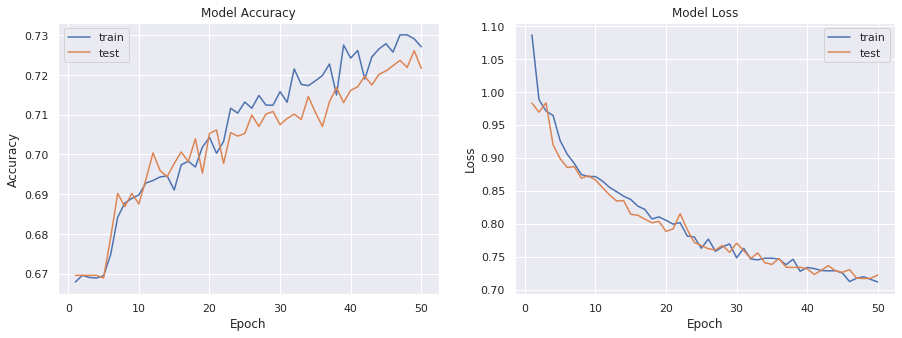

In [117]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'test'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'test'], loc='best')
    plt.show()

sns.set(style="darkgrid")
plot_model_history(history)



Above we see how the model learns a bit more with each epoch, and that the accuracy and loss remain similar in the train and test sets, meaning that the model does not  overfit on the train subset (which would have been indicated by increasing accuracies in the train dataset accompanied by a drop in accuracy in the test dataset). The accuracy never plateaus for either the train or test sets either, which means it would be reasonable to increase the number of epochs – especially given that I have included an EarlyStopping callback that would stop training if a plateau did eventually occur. Had I had additional resources, I would have tried this!

## Investigating evaluation metrics

In [118]:
loss, accuracy = model.evaluate_generator(test_generator, verbose=1)
v_datagen = ImageDataGenerator(rescale= 1./255)
v_generator = v_datagen.flow(x_val,y_val, batch_size=batch_size)
loss_v, accuracy_v = model.evaluate_generator(v_generator, verbose=1)

print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f \n" % (accuracy, loss))


32/32 [==============================] - 0s 5ms/step
Validation: accuracy = 0.729541  ;  loss_v = 0.741291
Test: accuracy = 0.721704  ;  loss = 0.722037 



An accuracy of >70% initially seems good, but I suspect this is a trap: after all, this dataset is heavily unbalanced and the model could just be taking advantage of this fact. 

So I want to explore these results further using other metrics. The "Balanced_accuracy_score" for example, is the macro-average of **recall** (or sensitivity) scores within each class, which is appropriate for multi-class problems. However, it does not weight the final value based on the number of true instances of each label. Looking at the **weighted mean** gives am additional insight on unbalanced datasets such as this one.  In addition, the **F1-score**  seeks a balance between recall (out of all the trully positive samples, what proportion were correctly predicted as positive) and **precision** (out of all the samples predicted as positives, what proportion was of really true positives), which is also relevant in unbalanced datasets. I will thus be reporting all of these from now on. 


As a disclaimer: in order to chose the evaluation metric in a real setting I would always prefer to talk to stakeholders (e.g. medical doctors) to understand what are the exact consequences of false positives or false negatives in each context, so I could decide on the metric accordingly. For example, for life threatening diseases, it is much "better" to have a false positive than a "false negative" diagnosis, as the latter could cause the patient to be denied treatment and have terrible consequences for their health. However, a toxic treatment also should never be offered to a healthy patient, in which case a "false positive" is also very bad. I do not fully understand the consequences of misclassifying skin lesions, so here I am assuming that we would need a balance between recall and precision, but I would definitely investigate this further before settling for a specific evaluation metric.







In [119]:
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Predict diagnosis from the validation dataset
y_pred = np.argmax(model.predict_generator(v_generator), axis=1)
print('\n \nBalanced accuracy on validation set:', balanced_accuracy_score(y_true=np.argmax(y_val,axis=1), y_pred=y_pred))

# Predict diagnosis from the latest test dataset
y_pred_train = np.argmax(model.predict(x_train[test]), axis=1)
print('Balanced accuracy on test set: %f \n' % balanced_accuracy_score(y_true=np.argmax(y_train[test],axis=1), y_pred=y_pred_train))

# Print metrics report
report = classification_report(y_true=np.argmax(y_val,axis=1), y_pred=y_pred, target_names=label_names, zero_division=0)
print(report);



 
Balanced accuracy on validation set: 0.14804892432664854
Balanced accuracy on test set: 0.143236 

              precision    recall  f1-score   support

       akiec       0.04      0.06      0.05        33
         bcc       0.03      0.04      0.04        51
         bkl       0.15      0.09      0.11       110
          df       0.00      0.00      0.00        12
         mel       0.12      0.08      0.10       111
          nv       0.69      0.76      0.72       671
        vasc       0.00      0.00      0.00        14

    accuracy                           0.53      1002
   macro avg       0.15      0.15      0.15      1002
weighted avg       0.49      0.53      0.51      1002



As I suspected, something seems fishy: despite the high accuracy of my trained method (> 70%), the balanced accuracy on the validation set is only ~15%! I suspect my model did not learn well from the small and imbalanced dataset.

Here I explore this further, by plotting a confusion matrix to show each sample's real label versus what label was predicted by my model:


Normalized confusion matrix


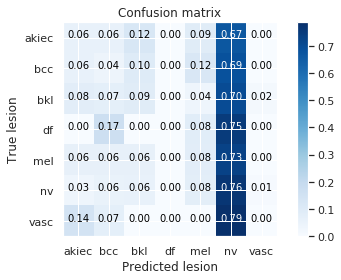

In [130]:
# Plot Confusion Matrix. Code taken from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(matrix, labels,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels) #, rotation=45)
    plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True lesion')
    plt.xlabel('Predicted lesion')
    plt.tight_layout()
    plt.grid(b=None)


# Convert validation observations from one hot vectors
y_true = np.argmax(y_val,axis = 1) 

# plot the confusion matrix
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
plot_confusion_matrix(conf_matrix, labels=label_names, normalize=True) 

As suspected, it looks like my model has learned to just call almost everything "nv" so that it gets good classification rates!

This can be confirmed by looking at the proportion of missclassified samples per class as per the plot below:

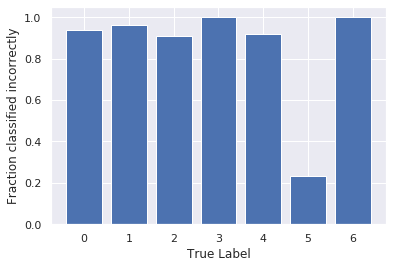

In [133]:
def plot_fractional_error(confusion_mtx):
    label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
    plt.bar(np.arange(7),label_frac_error)
    plt.xticks()
    plt.xlabel('True Label')
    plt.ylabel('Fraction classified incorrectly');

plot_fractional_error(confusion_mtx)

Besides the fact that the dataset is unbalanced, my choice of a very deep network for such a small dataset (even with data augmentation) is not ideal, as there are too many parameters to be trained in such a model. This led me to consider using a pre-trained model for my next step, as well as informing the model about the class imbalance, as you can see below.

In [0]:
# Clear memory
del df
del model
del history






---




---



# Second attempt: 
##Transfer learning +  class weights as a parameter for the classifier



---




---






My first attempt, relying on my custom neural network's ability to learn from an unbalanced dataset on its own, did not work well.

Thus, my new approach uses **Transfer Learning** by adopting a pretrained model as a base for my classifier, for which I only need to train the final layers using the HAM10000 dataset. 

In addition, I now inform my classifier that the dataset is unbalanced and that as a result it must try to learn more from underrepresented classes, as discussed further ahead. 

In [0]:
# Read pickled dataframe containing images resized to 224 x 224 to be used with Keras' pretrained models
base_path = '/content/drive/My Drive/Colab Notebooks/Data/SkinLesions/'
df_DenseNet = pd.read_pickle(os.path.join(base_path, 'HAM10000_metadata255x255.pkl')) 

# 1) Splitting train / test data

Like before, I separate a portion of my dataset that will never be seen during the classifier's learning steps, for the final validation. The remaining data is then split into train and test data, to be used for learning.

In [0]:
# Putting a testing dataset aside
x_train, x_test, y_train, y_test = train_test_split(np.array(df_DenseNet['image'].tolist()), 
                                                  df_DenseNet['lesion_cat'], test_size=0.1, 
                                                  random_state=2, stratify=df_DenseNet['lesion_cat'])

# Putting a final validation dataset aside
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, 
                                                  random_state=2, stratify=y_train)

# 2) Setting up the model

Here, I propose to use Keras' DenseNet201 pretrained on ImageNet as a base model, then adding an average pooling layer followed by a dense layer for predictions.

In [0]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [10]:
base_model = DenseNet201(include_top=False, weights='imagenet', input_shape=(224,224,3),
                         backend=keras.backend, layers = keras.layers, models = keras.models, utils = keras.utils)

def prepare_model(base_model):
  
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    preds = Dense(7,activation='softmax')(x)

    model = Model(inputs=base_model.input,outputs=preds)
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
      
model_DenseNet = prepare_model(base_model)

74842112/74836368 [==============================] - 2s 0us/step


## Callbacks and Data Augmentation

Below I set the callbacks for the new model. Note that I chose "patience = 15" for early stopping, although I only run 10 epochs. This is just to illustrate that, ideally, I would have a much larger number of epochs in the method and use this callback to avoid overfitting.

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0, mode='min')

checkpoint_saving = ModelCheckpoint('model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.5, min_lr=0.0001 , patience=3,
                                   verbose=1, min_delta=1e-4, mode='min')


# Data Augmentation
datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

datagen.fit(x_train)

# 3) Train Model

**Dealing with the imbalanced nature of the dataset:** As I learned early on, the class distribution in this dataset is heavily imbalanced, and my initial model was not able to learn well without taking this into consideration. Besides, the proportion of samples avaible per class reflects the real-world scenario (instead of being just and artifact of the data collection procedure). For this reason, this time around I decided to tell my model to weight what it learns from the loss of each class differently.  By setting the *class_weight* parameter when fitting the model, I am instructing it to pay more attention to under-represented classes.

In [12]:
batch_size = 32
history = model_DenseNet.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              validation_data=(x_val, y_val, compute_sample_weight('balanced', y_val)),
                              class_weight=compute_class_weight('balanced', np.unique(y_train), y_train),
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              epochs=10,
                              callbacks=[early_stopping, checkpoint_saving, reduce_lr_rate])

Epoch 1/10
225/225 [==============================] - 176s 782ms/step - loss: 0.8329 - acc: 0.7013 - val_loss: 1.9572 - val_acc: 0.5530
Epoch 2/10
225/225 [==============================] - 99s 441ms/step - loss: 0.7333 - acc: 0.7358 - val_loss: 1.8252 - val_acc: 0.6900
Epoch 3/10
225/225 [==============================] - 99s 441ms/step - loss: 0.6898 - acc: 0.7424 - val_loss: 3.4444 - val_acc: 0.6805
Epoch 4/10
225/225 [==============================] - 99s 441ms/step - loss: 0.6796 - acc: 0.7541 - val_loss: 2.2939 - val_acc: 0.6966
Epoch 5/10
225/225 [==============================] - 99s 442ms/step - loss: 0.6481 - acc: 0.7632 - val_loss: 2.0892 - val_acc: 0.7221

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/10
225/225 [==============================] - 99s 440ms/step - loss: 0.5654 - acc: 0.7858 - val_loss: 1.7720 - val_acc: 0.7499
Epoch 7/10
225/225 [==============================] - 99s 439ms/step - loss: 0.5517 - acc: 0.7931 - val_loss

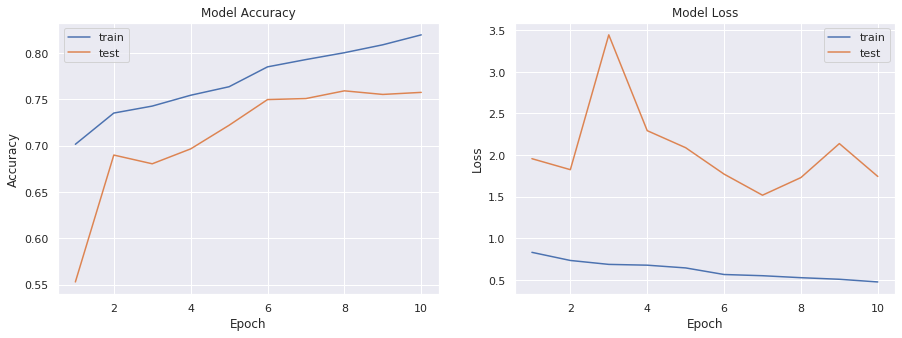

In [32]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'test'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'test'], loc='best')
    plt.show()
plot_model_history(history)

In [0]:
# Save/load the saved model and avoid having to retrain it all over again!

model_path = os.path.join(base_path, 'modelDenseNet201.h5')
model_DenseNet.save(model_path)
#model_DenseNet = load_model(model_path)


In [0]:
# Save/load the training history for the DenseNet-based model :)
import pickle

hist_path = os.path.join(base_path, 'trainHist.pkl')
with open(hist_path, 'wb') as file_pi:
        pickle.dump(history, file_pi)


#with open(hist_path, 'rb') as file_pi:
#       history = pickle.load(file_pi) 

# 4) Evaluate on Test and Validation Sets

In [18]:
#model_DenseNet.load_weights('model.hdf5')

# Evaluate on set separated for testing during training
y_pred_t = np.argmax(model_DenseNet.predict(x_test), axis=1)
print('Balanced accuracy on test set:', balanced_accuracy_score(y_true=y_test, y_pred=y_pred_t))

# Evaluate on final validation set, which was never seen by my model
y_pred = np.argmax(model_DenseNet.predict(x_val), axis=1)
print('Balanced accuracy on validation set:', balanced_accuracy_score(y_true=y_val, y_pred=y_pred))

Balanced accuracy on test set: 0.4486690716887714
Balanced accuracy on validation set: 0.4460299471138784


Normalized confusion matrix


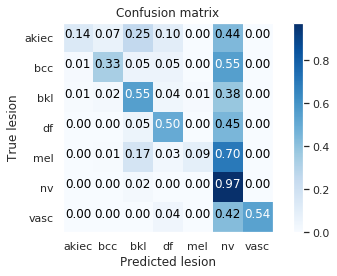

In [28]:
conf_matrix = confusion_matrix(y_true=y_val, y_pred=y_pred)
plot_confusion_matrix(conf_matrix, labels=label_names, normalize=True)

This confusion matrix already looks a lot more loaded on the diagonal than the previous one, although there's still a tendency to classify as class nv. 

In [30]:
report = classification_report(y_true=y_val, y_pred=y_pred, target_names=label_names, zero_division=0)
print(report);

              precision    recall  f1-score   support

       akiec       0.80      0.14      0.23        59
         bcc       0.76      0.33      0.46        93
         bkl       0.57      0.55      0.56       198
          df       0.26      0.50      0.34        20
         mel       0.90      0.09      0.16       200
          nv       0.79      0.97      0.87      1207
        vasc       0.93      0.54      0.68        26

    accuracy                           0.76      1803
   macro avg       0.72      0.45      0.47      1803
weighted avg       0.77      0.76      0.71      1803



The above results, with a macro average recall of 45% (76% weighted average) is a major improvement on the first model I tried. There are several ways it could be further improved, as discussed in the section "Future Directions".

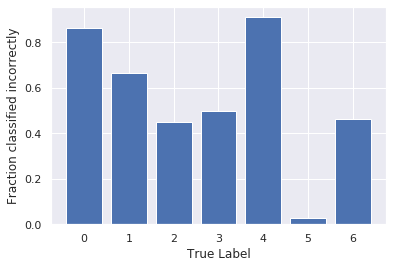

In [35]:
plot_fractional_error(conf_matrix)

Worryingly, Melanoma is the lesion type with the highest rate of missclassified samples, showing the importance of additional fine tuning to this model! 

# 5) Visualise final results

Finally, I would like to visualise some validation images, their true class, and how they were classified.

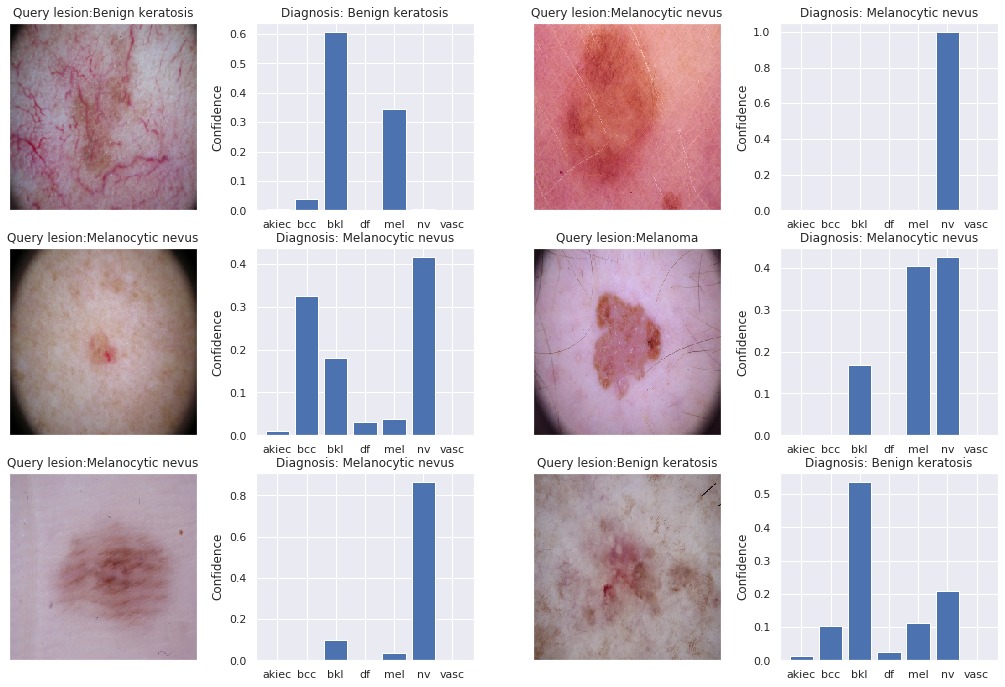

In [173]:
import matplotlib.pyplot as plt
%matplotlib inline

i = j =  0
text_labels = []
f = plt.figure(figsize = (18,20))
columns = 4

for index in np.random.randint(0, len(x_val), 6):
    image = x_val[index:index+1]
    pred = model_DenseNet.predict(image)
    predClass = pred.argmax()
    text_labels.append(dict_lesion_cat.get(predClass))
    plt.subplot(5, columns, i+1)
    plt.title('Query lesion:' + dict_lesion_cat.get(y_val.iloc[index]))
    imgplot = plt.imshow((image[0][:,:,::]).astype('uint8'))
    i += 1
    
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    
    plt.subplot(5, columns, i+1)
    #plt.xticks(range(len(pred)), folders)
    y_pos = np.arange(len(pred[0]))
    plt.bar(y_pos,pred[0])
    plt.xticks(y_pos, label_names)
    plt.ylabel('Confidence')
    plt.title('Diagnosis: '+ text_labels[j])
    
    i += 1
    j += 1
    if j % 6 == 0:
        break;
plt.show()


From this random sample, we can see that the classifier was very confused for the Melanoma sample, giving it almost equal confidence values for the classes Melanoma and Melanocytic nevus. I believe that with additional fine tuning the model would learn to better distinguish between all classes.

# 6) Future directions:


Here are a few other ideas I would have loved to have explored (and probably will :-) ):



* Since I've added the EarlyStopping callback, I could have added a very large number of Epochs without worrying about overfitting, since training would stop when the accuracy stops improving in the test dataset. I haven't done that yet due to the time constraint. 
* Also for time constraints, I haven't added cross-validation to my second solution, as it lakes longer to run. If I had the appropriate infrastructure I would choose to add it to make my results more generalisable, besides making a more efficient use of the small dataset. 
* Include all other features (e.g., body location, etc) in the classification problem, instead of only using the images alone 
* Optimise the models' hyperparameters (e.g. batch_size) using GridSearchCV
* Customise the model's optimiser. I was only able to train my model in Google Colaboratory using a batch size of 32, which is quite small given than one of the classes (dermatofribroma) represents less than 1% of the dataset. This means that in many cases the model's weights may have been updated without this class having even been seen at all! I could address this using Gradient Accumulation, where optimiser steps would only be taken after several batches (storing the loss at each batch), thus increasing the effective batch size.
* Test other pretrained models and compare the results!


